In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run stochastic_lstm_optimizer.py

In [3]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', **kwargs):
        n_steps = T.iscalar()
        
        l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
        self.l_optim = LSTMOptimizerLayer(l_input, n_steps=n_steps, function=func, **kwargs)
        
        self.params_init = L.layers.get_all_param_values(self.l_optim)

        theta_history, loss_history = L.layers.get_output(self.l_optim)
        self.loss_type = loss_type
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = T.log(loss_history).sum()
        elif loss_type == 'weighted_prod':
            loss = (T.log(loss_history) * 0.9**T.arange(loss_history.shape[0])[::-1]).sum()
                
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.l_optim, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        optimizer_loss = []
        optimizer_moving_loss = []
        moving_loss = None
        
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                if self.loss_type == 'sum':
                    loss = np.sum(loss_history)
                else:
                    loss = np.sum(np.log(loss_history))
                training_loss_history.append(loss_history)
            
                optimizer_loss.append(loss)
                if moving_loss is None:
                    moving_loss = loss
                else:
                    moving_loss = 0.9 * moving_loss + 0.1 * loss
                optimizer_moving_loss.append(moving_loss)

            display.clear_output(wait=True)
            plt.figure(figsize=(15, 12))
            
            plt.subplot(2, 1, 2)
            plt.semilogy(np.median(training_loss_history, axis=0))
            
            plt.subplot(2, 1, 1)
            if self.loss_type == 'sum':
                plt.semilogy(optimizer_loss, 'b', label='loss')
                plt.semilogy(optimizer_moving_loss, 'r', label='moving loss')
            else:
                plt.plot(optimizer_loss, 'b', label='loss')
                plt.plot(optimizer_moving_loss, 'r', label='moving loss')
            
            plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [4]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [5]:
W = T.matrix()
b = T.vector()
    
func = lambda theta: QuadraticFunction(theta, W, b).func

In [6]:
input_var = T.vector()

In [7]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [8]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [10]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
    'preprocess_input': False,
}

# for n_gac in [0, 5]:
#     for loss_type in ['sum', 'prod']:
#         options['n_gac'] = n_gac
#         options['loss_type'] = loss_type
        
#         key = "n_gac={}; loss_type={}".format(n_gac, loss_type)
#         lstm_optimizers[key] = LSTMOptimizer(input_var, func, [W, b], **options)

for n_gac in [5]:
    for loss_type in ['sum']:
        options['n_gac'] = n_gac
        options['loss_type'] = loss_type
        
        key = "n_gac={}; loss_type={}".format(n_gac, loss_type)
        lstm_optimizers[key] = LSTMOptimizer(input_var, func, [W, b], **options)

In [31]:
def sample_params(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.random.randn(ndim, ndim))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point(ndim):
    theta = np.cast['float32'](np.random.randn(ndim))
    return theta

def sample_point_and_params(ndim=None):
    W, b = sample_params(ndim)
    theta = sample_point(len(b))
    
    return theta, (W, b)

#data = [sample_point_and_params(ndim=ndim+1) for _ in range(10) for ndim in range(20)]
data = [sample_point_and_params(ndim=ndim+1) for _ in range(200) for ndim in range(10)]
np.random.shuffle(data)
data_index = 0

def sample_from_data():
    global data_index
    theta, (W_, b_) = data[data_index]
    data_index = (data_index + 1) % len(data)
    return theta, (W_, b_)

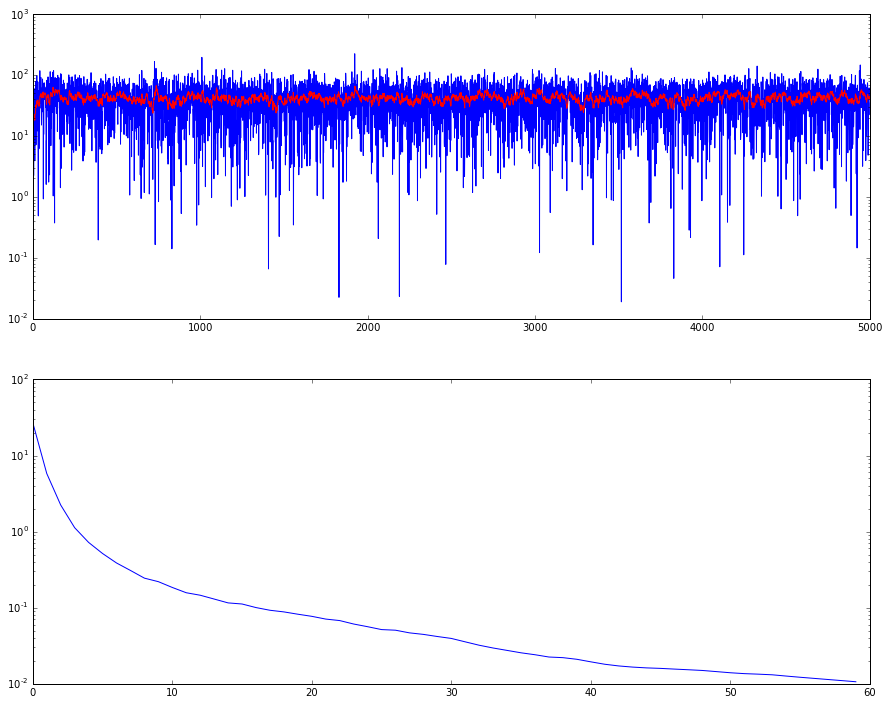

Epoch number 49
Time on epoch 49: 7.984739542007446
Loss on 49: 44.072113699803594; 0.010642120614647865


In [80]:
training_options = {
    'n_iter': 60,
    'n_epochs': 50,
    'batch_size': 100,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    if key.find('n_gac=5; loss_type=sum') != -1:
#         opt.lr.set_value(0.01 * 0.96**100)
#         opt.reset_network()
        opt.train(sample_point_and_params, **training_options)

In [19]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [20]:
def test_optimizers(**testing_options):
    thetas_and_params = [sample_point_and_params() for _ in range(testing_options['n_functions'])]
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
        plt.semilogy(np.median(loss_history, axis=0), label='lstm; {}'.format(key))

#    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    lrates = np.logspace(0, 19, num=20, base=2.0) * 1e-6
#     lrates = [0.008192]
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        plt.semilogy(best_history, label="{name}; lr={best_lrate}".format(**locals()), linestyle='--')

    plt.legend()
    plt.show()

Testing lstm; n_gac=5; loss_type=sum
Testing momentum


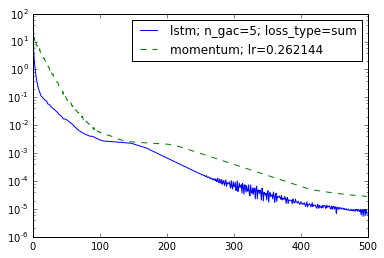

In [41]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
}

test_optimizers(**testing_options)

In [73]:
theta, (W_, b_) = sample_point_and_params(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)

sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 0.262144)
    
# for name, opt in non_lstm_optimizers.items():
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#             history, losses = opt(theta, 300, W_, b_, lrate)
#             history = [theta] + history

#             sample_runs["{}; lr={}".format(name, lrate)] = (history, losses)

[ 2.84292221 -1.9827342 ]


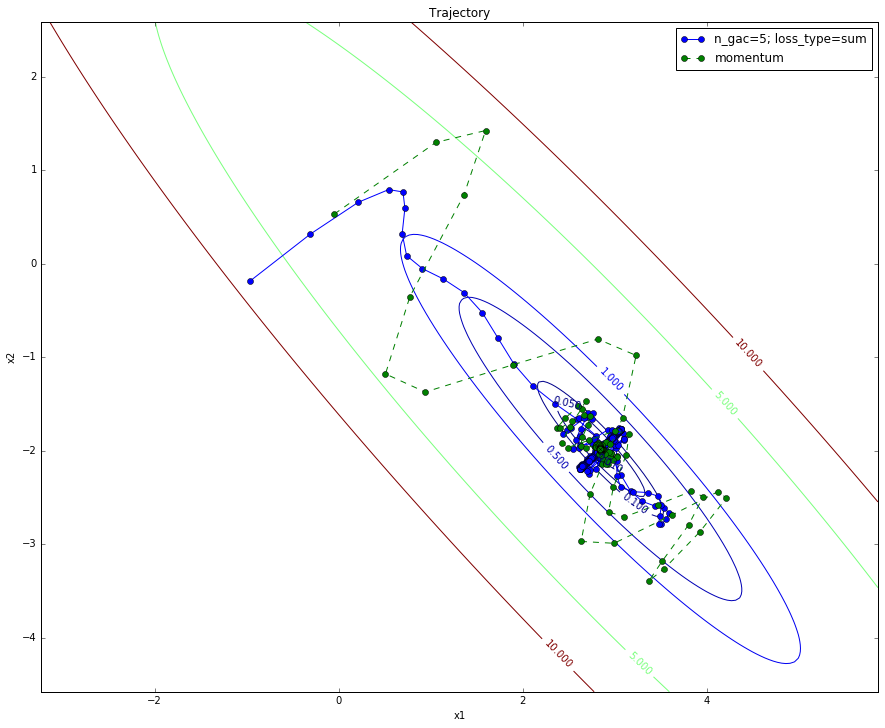

In [74]:
theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
# x = np.arange(min_x, max_x, delta_x)
# y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

#Z = ((W.dot(X) - b_)**2).sum()

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in lstm_optimizers:
    history, _ = sample_runs[name]
    plt.plot(history.T[0], history.T[1], marker='o', label=name)

history, _ = sample_runs['momentum']
plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#         #if 1e-4 < lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             history, _ = sample_runs[key]
#             plt.plot(np.array(history).T[0], np.array(history).T[1], label=key, marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

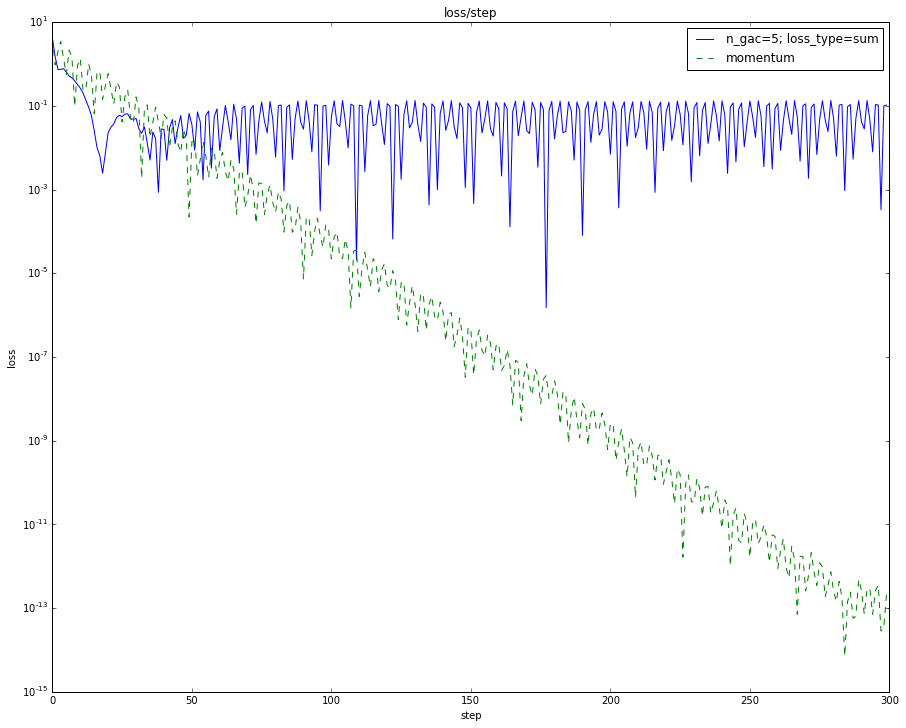

In [75]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in lstm_optimizers:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name)

_, losses = sample_runs['momentum']    
plt.semilogy(losses, label='momentum', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008912:
#         #if lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             _, losses = sample_runs[key]
#             plt.semilogy(losses, label=key, linestyle='--')
plt.legend();

In [89]:
# generalization_loss_lstm = {name: [] for name in lstm_optimizers}

for n_c in range(2, 150):
    print(n_c)
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for _ in range(10):
            theta, (W_, b_) = sample_point_and_params(ndim=n_c)    
            #loss = 1. / n_c * opt.optimize(theta, [W_, b_], 100)[1][-1]
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm[name].append(np.mean(losses))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


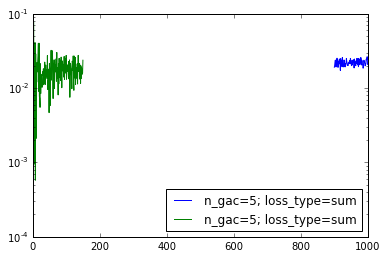

In [90]:
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(range(900, 1000), losses[:100], label=name)
    plt.semilogy(range(2, 150), losses[100:], label=name)
plt.legend(loc=4);

In [25]:
for name, opt in lstm_optimizers.items():
    np.savez('2layer_div_dim_noprep_optimizer_({}).npz'.format(name), L.layers.get_all_param_values(opt.l_optim))

Testing lstm; n_gac=0; loss_type=sum
Testing lstm; n_gac=0; loss_type=prod
Testing lstm; n_gac=5; loss_type=prod
Testing lstm; n_gac=5; loss_type=sum
Testing momentum


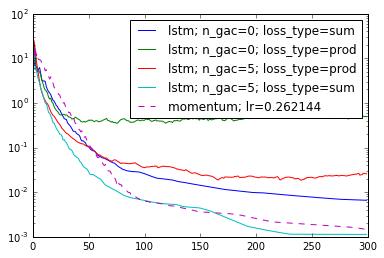

In [26]:
testing_options = {
    'n_iter': 300,
    'n_functions': 50,
}

test_optimizers(**testing_options)

In [5]:
import theano.sandbox.cuda.basic_ops as sbcuda
print(sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]/1024./1024/1024)

4.116977691650391


Testing lstm; n_gac=5; loss_type=sum
Testing momentum


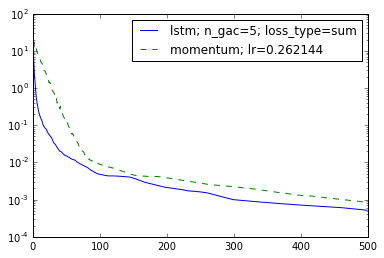

In [81]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
}

test_optimizers(**testing_options)